# Vehicle Detection

This is part of the Udacity self driving car Nanodegree.

## The Project

The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

# Imports

In [1]:
import os
import urllib.request
from urllib.request import urlretrieve
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
from scipy.ndimage.measurements import label

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve

from moviepy.editor import VideoFileClip
from IPython.display import HTML

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

%matplotlib inline
plt.rcParams["figure.figsize"] = 16, 10

# Training a SVM to detect vehicles

## Global feature setting

In [2]:
color_space = "YCrCb"
orient = 11
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32,32) 
hist_bins = 32
spatial_feat = True 
hist_feat = True 
hog_feat = True

## Downloading the Data

In [3]:
!mkdir data

mkdir: data: File exists


In [4]:
def download_file(source, destination_folder):
    filename = source.split("/")[-1]
    if not os.path.exists("./" + destination_folder +"/" + filename):
        print("Images not yet downloaded, downloading...")
        urlretrieve(source, destination_folder +"/" + filename)
        print("extracting...")
        zip_ref = zipfile.ZipFile("./" + destination_folder +"/" + filename, 'r')
        zip_ref.extractall(destination_folder)
        zip_ref.close()    
        print("done!")
    else:
        print("Images already downloaded.")

In [5]:
download_file("https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip", "./data")

Images already downloaded.


In [6]:
download_file("https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip", "./data")

Images already downloaded.


## Loading the data

The images got extracted from videos. So there will be a lot of very similar images. This is a problem when training and testing a classifier, as it is easier to classify images that the classifier has already seen or are very similiar to images that the classifier has already seen. The images are ordered by by numbers in their filename. Images of similiar cars have close by numbers. So images will be sampled by their image numbers into a training and test set, so that there should be almost no similiar images in both sets.

In [7]:
def get_image_paths(directory):
    image_paths = []
    for dirpath, dirnames, filenames in os.walk(directory):
        for filename in [f for f in filenames if f.endswith(".png")]:
            image_paths.append(os.path.join(dirpath, filename))
    return image_paths

In [8]:
def get_folders_containing_images(directory):
    dirpaths = []
    for dirpath, dirnames, filenames in os.walk(directory):
        if len([f for f in filenames if f.endswith(".png")]) > 0:
            dirpaths.append(dirpath)
    return dirpaths


In [9]:
get_folders_containing_images("./data/vehicles/")

['./data/vehicles/GTI_Far',
 './data/vehicles/GTI_Left',
 './data/vehicles/GTI_MiddleClose',
 './data/vehicles/GTI_Right',
 './data/vehicles/KITTI_extracted']

In [10]:
def train_test_split_paths(directory, percent = 0.2):
    train_image_paths = []
    test_image_paths = []
    for folder in get_folders_containing_images(directory):
        images = get_image_paths(folder)
        number_of_images = len(images)
        images.sort()
        train_image_paths.extend(images[:int(number_of_images * (1 -percent))])
        test_image_paths.extend(images[int(number_of_images * (1 -percent)):])

    return train_image_paths, test_image_paths

    

In [11]:
train_car_image_paths, test_car_image_paths = train_test_split_paths("./data/vehicles/")
train_non_car_image_paths, test_non_car_image_paths = train_test_split_paths("./data/non-vehicles//")

In [12]:
print("Car Train Length: {} Car Test Length: {}".format(len(train_car_image_paths), len(test_car_image_paths)))
print("Non Car Train Length: {} Non Car Test Length: {}".format(len(train_non_car_image_paths), len(test_non_car_image_paths)))

Car Train Length: 7032 Car Test Length: 1760
Non Car Train Length: 7174 Non Car Test Length: 1794


In [13]:
def load_images(image_paths):
    result = []
    for image_path in image_paths:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        result.append(image)
    return result

In [14]:
car_images_train = load_images(train_car_image_paths)
car_images_test = load_images(test_car_image_paths)
non_car_images_train = load_images(train_non_car_image_paths)
non_car_images_test = load_images(test_non_car_image_paths)

## Data Examples

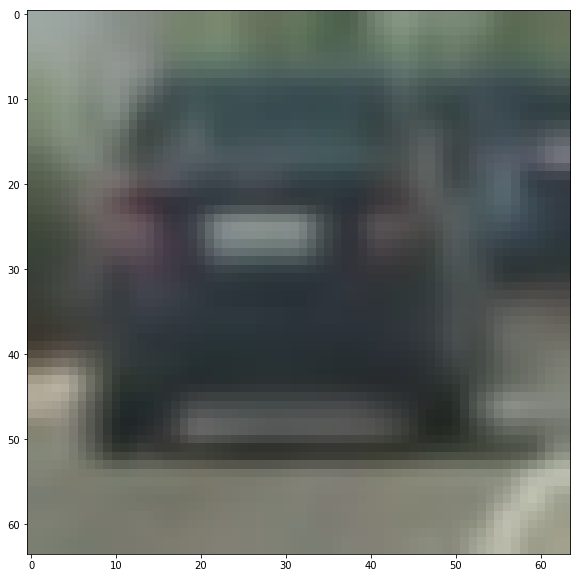

In [15]:
plt.imshow(car_images_train[0])

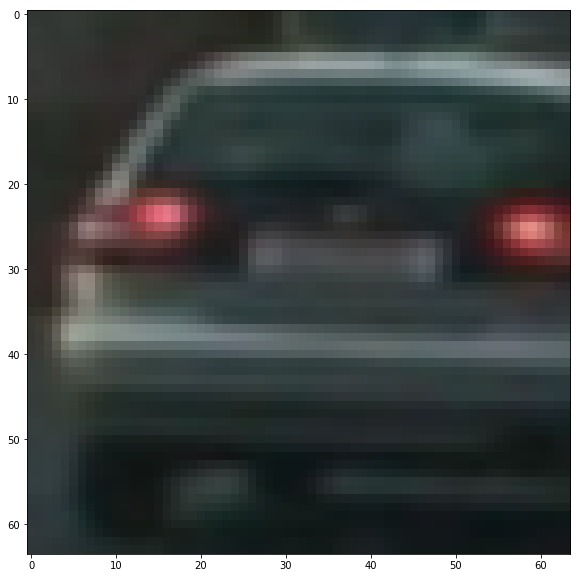

In [16]:
plt.imshow(car_images_test[0])

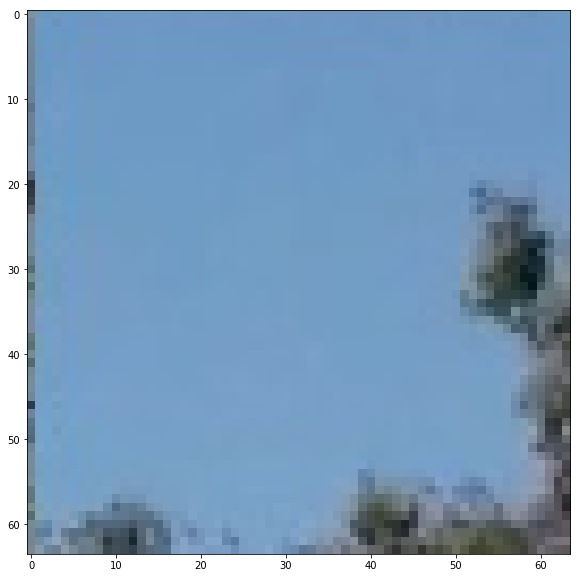

In [17]:
plt.imshow(non_car_images_train[0])

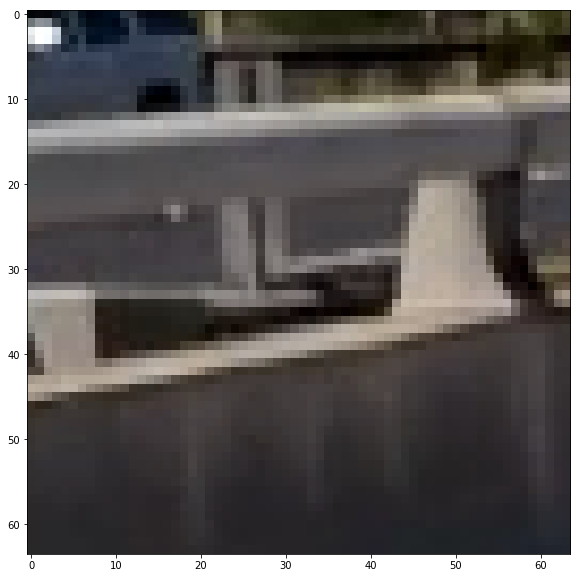

In [18]:
plt.imshow(non_car_images_test[0])

## Extracting Features from Images

These functions  got implemented in the udacity course.

In [19]:
# Define a function to compute color histogram features  
def color_hist(img, nbins, bins_range=(0, 255)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
    

In [20]:
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial(img, color_space, size):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    features = cv2.resize(feature_image, size).ravel() 
    return features

In [21]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

In [22]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []

        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, color_space=color_space, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


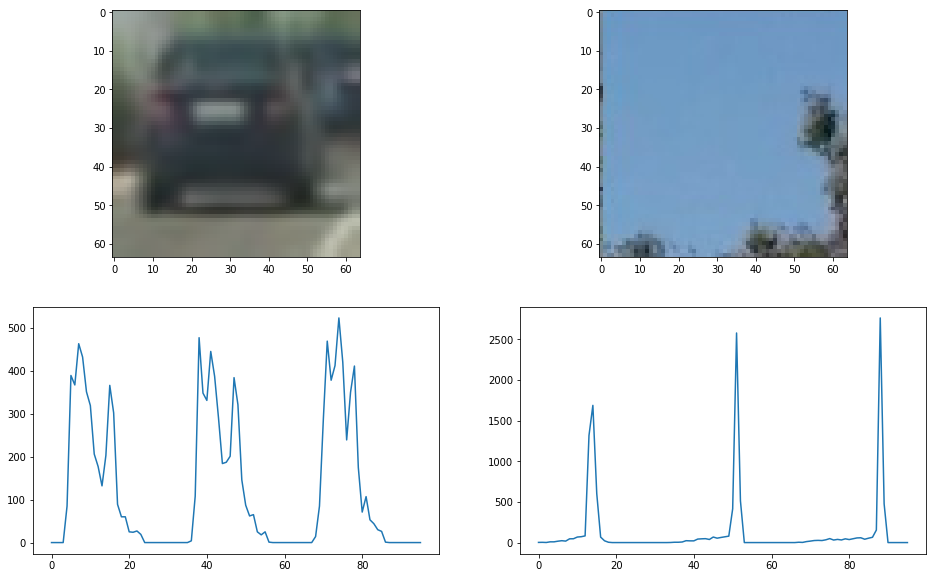

In [23]:
plt.subplot(221)
plt.imshow(car_images_train[0])
plt.subplot(222)
plt.imshow(non_car_images_train[0])
plt.subplot(223)
plt.plot(color_hist(car_images_train[0], nbins=hist_bins))
plt.subplot(224)
plt.plot(color_hist(non_car_images_train[0], nbins=hist_bins))

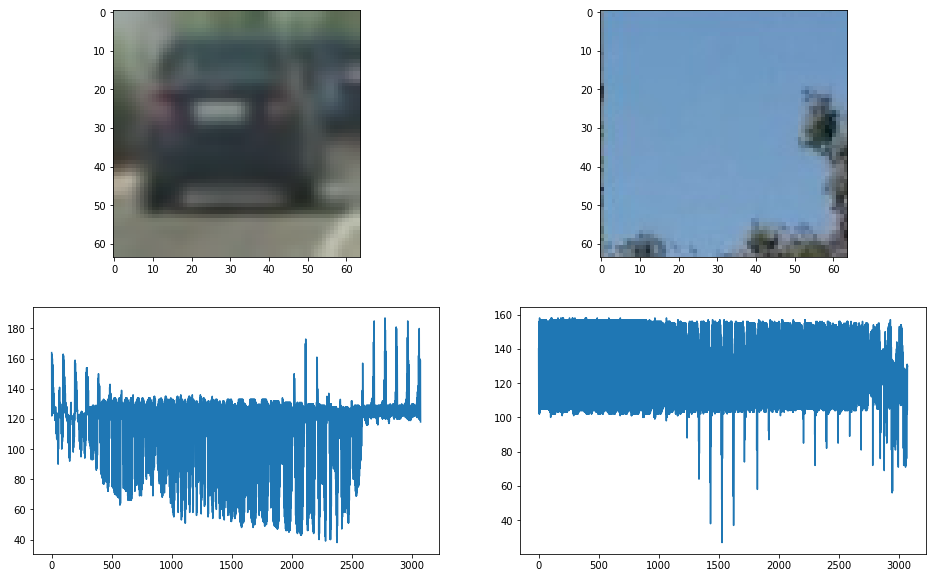

In [24]:
plt.subplot(221)
plt.imshow(car_images_train[0])
plt.subplot(222)
plt.imshow(non_car_images_train[0])
plt.subplot(223)
plt.plot(bin_spatial(car_images_train[0], color_space=color_space, size=spatial_size))
plt.subplot(224)
plt.plot(bin_spatial(non_car_images_train[0], color_space=color_space, size=spatial_size))

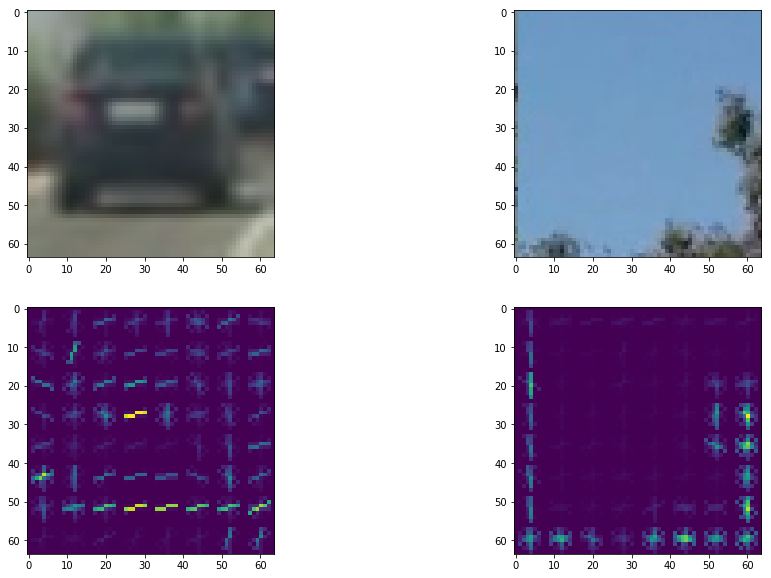

In [25]:
plt.subplot(221)
plt.imshow(car_images_train[0])
plt.subplot(222)
plt.imshow(non_car_images_train[0])
plt.subplot(223)
feat, vis = get_hog_features(car_images_train[0][:,:,1], orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, vis=True)
plt.imshow(vis)
plt.subplot(224)
feat, vis = get_hog_features(non_car_images_train[0][:,:,1], orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, vis=True)
plt.imshow(vis)


## Data Preparation

In [26]:
car_train_features = extract_features(car_images_train, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

car_test_features = extract_features(car_images_test, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_train_features = extract_features(non_car_images_train, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_test_features = extract_features(non_car_images_test, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X_train = np.concatenate([car_train_features, notcar_train_features]).astype(np.float64)
X_test = np.concatenate([car_test_features, notcar_test_features]).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)

# Define the labels vector
y_train = np.hstack((np.ones(len(car_train_features)), np.zeros(len(notcar_train_features))))
y_test = np.hstack((np.ones(len(car_test_features)), np.zeros(len(notcar_test_features))))


In [27]:
scaled_X_train.shape

(14206, 9636)

In [28]:
scaled_X_test.shape

(3554, 9636)

In [29]:
y_train.shape

(14206,)

In [30]:
y_test.shape

(3554,)

In [31]:
scaled_X_train[0]

array([ 1.2164238 ,  1.48853888, -0.86496589, ..., -1.07976137,
       -0.81328732, -0.38641233])

In [32]:
y_train[0]

1.0

## Training the SVM

In [33]:
parameters = {'C':[2]} #Found 2 to be the best parameter through previous grid searches
svc = LinearSVC()
gridsearch = GridSearchCV(svc, parameters, verbose = 1) 
gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.8min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=1, param_grid={'C': [2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [34]:
gridsearch.best_params_

{'C': 2}

## Testing the SVM

In [35]:
gridsearch.score(X_test, y_test)

0.94766460326392798

In [36]:
fpr, tpr, thresholds = roc_curve(y_test, gridsearch.predict(X_test))

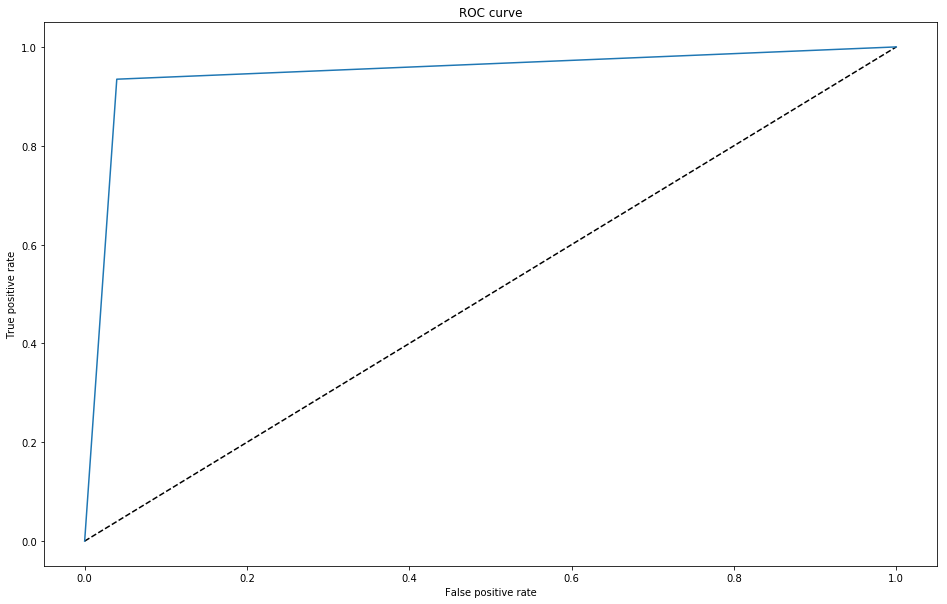

In [37]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')


# Detect Vehicles in an Image

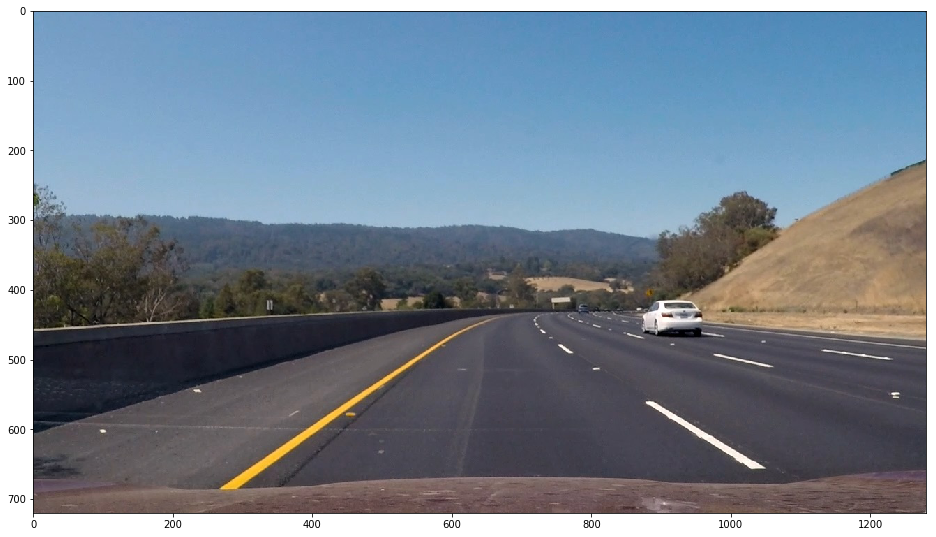

In [38]:
test_image = cv2.imread("./test_images/test3.jpg")
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
plt.imshow(test_image)

## Create a vehicleness heatmap

In [39]:

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [40]:

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient = 11, pix_per_cell = 8, cell_per_block = 2, spatial_size = (32,32), hist_bins = 32):

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    bbox = []

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, color_space=color_space,size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

    return bbox

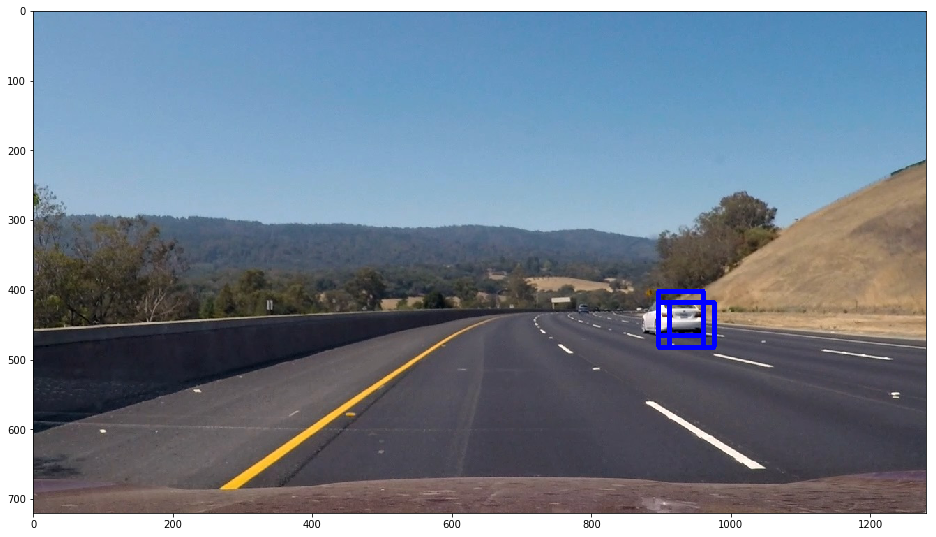

In [41]:
found_cars1 = find_cars(test_image, 370, 550, 1, gridsearch, X_scaler)
plt.imshow(draw_boxes(test_image, found_cars1))

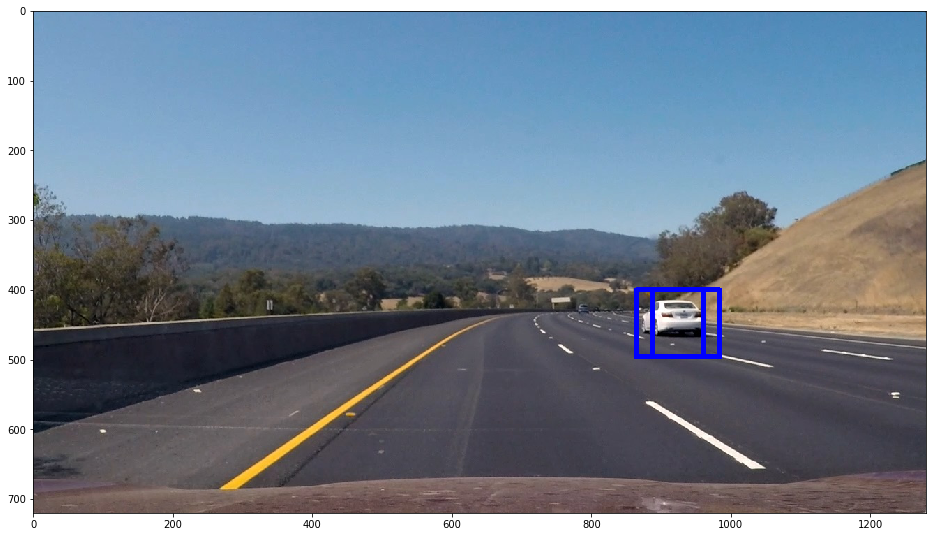

In [42]:
found_cars2 = find_cars(test_image, 400, 650, 1.5, gridsearch, X_scaler)
plt.imshow(draw_boxes(test_image, found_cars2))

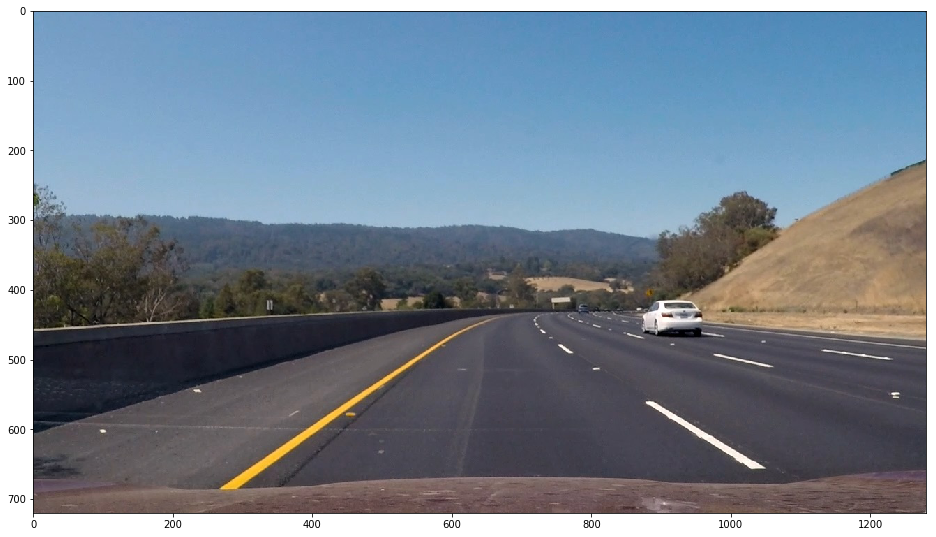

In [43]:
found_cars3 = find_cars(test_image, 400, 650, 2, gridsearch, X_scaler)
plt.imshow(draw_boxes(test_image, found_cars3))

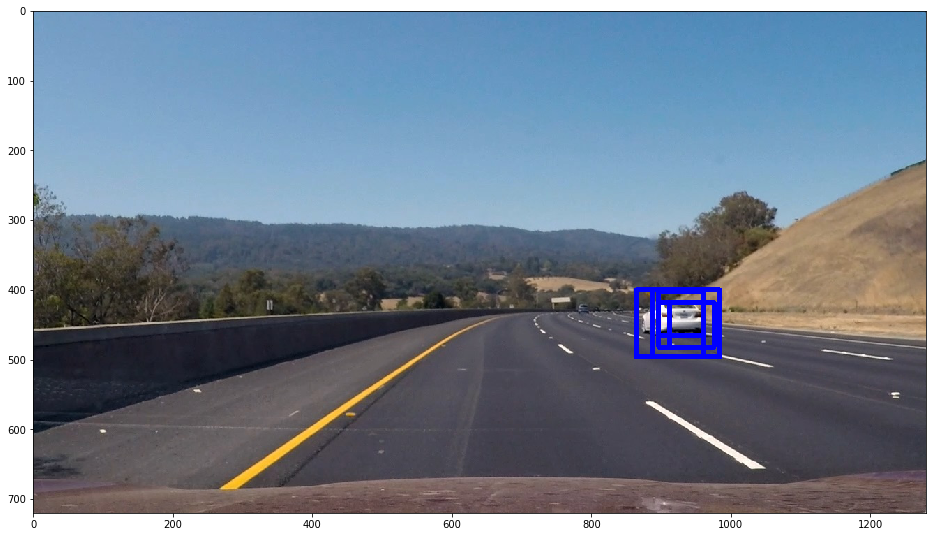

In [44]:
found_cars = []
found_cars.extend(found_cars1)
found_cars.extend(found_cars2)
found_cars.extend(found_cars3)

plt.imshow(draw_boxes(test_image, found_cars))

In [45]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [46]:
class Heat_history:
    def __init__(self, length):
        self.heatmaps = []
        self.length = length
        
    def add_heatmap(self, heatmap):
        while len(self.heatmaps) > self.length:
            self.heatmaps.pop(0)
        self.heatmaps.append(heatmap)
        
    def get_avg_heatmap(self):
        return np.average(self.heatmaps, axis=0)

In [92]:
def find_cars_in_image(image, return_heat_map = False, overlay_heat=True, return_boxes_only = False):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    found_cars = find_cars(image, 370, 550, 1, gridsearch, X_scaler)
    found_cars.extend(find_cars(image, 400, 650, 1.5, gridsearch, X_scaler))
    found_cars.extend(find_cars(image, 400, 650, 2, gridsearch, X_scaler))

    if return_boxes_only:
        return found_cars

    # Add heat to each box in box list
    heat = add_heat(heat,found_cars)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,4)
    
    if heat_history:
        heat_history.add_heatmap(heat)
        heat = heat_history.get_avg_heatmap()

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    if return_heat_map:

        return draw_img, heatmap
    else:
        return draw_img

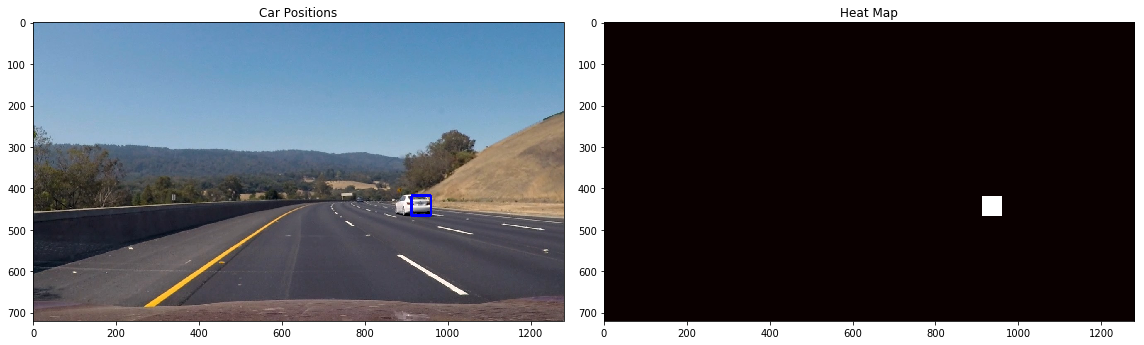

In [93]:
heat_history = Heat_history(1)

draw_img, heatmap = find_cars_in_image(test_image, return_heat_map=True)
fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


In [80]:
test_image_paths = glob.glob("./test_images/*")
images = []
for path in test_image_paths:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)

In [81]:
len(images)

6

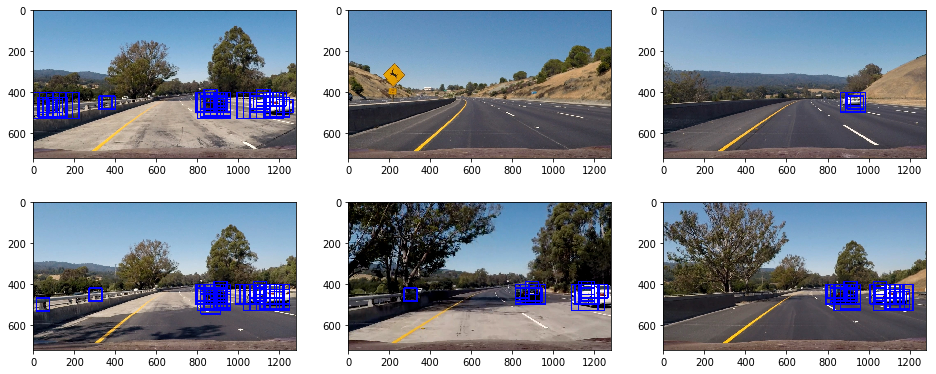

In [89]:
i = 1
for image in images:
    plt.subplot(3,3,i)
    boxes = find_cars_in_image(images[i-1], return_boxes_only=True)
    plt.imshow(draw_boxes(images[i-1], boxes))
    i += 1

# Detect Vehicles in Videos

In [49]:
!mkdir video_out

mkdir: video_out: File exists


## Testvideo

In [50]:
heat_history = Heat_history(10)
output = 'video_out/test_video.mp4'
clip1 = VideoFileClip("./test_video.mp4")
white_clip = clip1.fl_image(find_cars_in_image)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video video_out/test_video.mp4
[MoviePy] Writing video video_out/test_video.mp4


 97%|█████████▋| 38/39 [00:41<00:01,  1.09s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_out/test_video.mp4 

CPU times: user 39.2 s, sys: 2.37 s, total: 41.5 s
Wall time: 41.9 s


In [51]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

## Video Parts

There are some parts of in the video where some problems are visible. Especially when the white car is far away. Here we will create some subclips to run the detection on.

In [52]:
clip1 = VideoFileClip("./project_video.mp4")
no_cars_clip = clip1.subclip(0,5)
white_car_near_clip = clip1.subclip(10,15)
white_car_far_clip = clip1.subclip(20,25)
black_car_near_clip = clip1.subclip(30,35)


In [53]:
!mkdir tmpvideos

mkdir: tmpvideos: File exists


### No Car

In [54]:
heat_history = Heat_history(10)
output = 'tmpvideos/no_cars_clip.mp4'
white_clip = no_cars_clip.fl_image(find_cars_in_image)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video tmpvideos/no_cars_clip.mp4
[MoviePy] Writing video tmpvideos/no_cars_clip.mp4


 99%|█████████▉| 125/126 [02:13<00:01,  1.06s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: tmpvideos/no_cars_clip.mp4 

CPU times: user 2min 7s, sys: 7.02 s, total: 2min 14s
Wall time: 2min 13s


In [55]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### White Car Near

In [56]:
heat_history = Heat_history(10)
output = 'tmpvideos/white_car_near_clip.mp4'
white_clip = white_car_near_clip.fl_image(find_cars_in_image)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video tmpvideos/white_car_near_clip.mp4
[MoviePy] Writing video tmpvideos/white_car_near_clip.mp4


 99%|█████████▉| 125/126 [02:15<00:01,  1.08s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: tmpvideos/white_car_near_clip.mp4 

CPU times: user 2min 8s, sys: 7.97 s, total: 2min 16s
Wall time: 2min 16s


In [57]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### White car far

In [58]:
heat_history = Heat_history(10)
output = 'tmpvideos/white_car_far_clip.mp4'
white_clip = white_car_far_clip.fl_image(find_cars_in_image)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video tmpvideos/white_car_far_clip.mp4
[MoviePy] Writing video tmpvideos/white_car_far_clip.mp4


 99%|█████████▉| 125/126 [02:14<00:01,  1.07s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: tmpvideos/white_car_far_clip.mp4 

CPU times: user 2min 8s, sys: 7.37 s, total: 2min 15s
Wall time: 2min 15s


In [59]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Black Car

In [60]:
heat_history = Heat_history(10)
output = 'tmpvideos/black_car_near_clip.mp4'
white_clip = black_car_near_clip.fl_image(find_cars_in_image)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video tmpvideos/black_car_near_clip.mp4
[MoviePy] Writing video tmpvideos/black_car_near_clip.mp4


 99%|█████████▉| 125/126 [02:14<00:01,  1.08s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: tmpvideos/black_car_near_clip.mp4 

CPU times: user 2min 8s, sys: 7.62 s, total: 2min 15s
Wall time: 2min 15s


In [61]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

## Project Video

In [62]:
heat_history = Heat_history(10)
output = 'video_out/project_video.mp4'
white_clip = clip1.fl_image(find_cars_in_image)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video video_out/project_video.mp4
[MoviePy] Writing video video_out/project_video.mp4


100%|█████████▉| 1260/1261 [23:06<00:01,  1.09s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_out/project_video.mp4 

CPU times: user 21min 49s, sys: 1min 25s, total: 23min 14s
Wall time: 23min 7s


In [63]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))